In [1]:
!pip install indic-nlp-library
!pip install torch
!pip install torchtext
!pip install spacy
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 4.7 MB/s 
     |████████████████████████████████| 2.8 MB 42.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 4.8 MB/s 
     |████████████████████████████████| 138 kB 49.1 MB/s 
     |████████████████████████████████| 127 kB 51.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take int

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext import data
from torchtext import datasets

from collections import Counter
from torchtext.vocab import vocab

import numpy as np
import random

import pandas as pd
import re

import sys
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:

from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/AML_Project/
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/AML_Project"

Mounted at /content/gdrive
/content/gdrive/MyDrive/AML_Project


In [5]:


df = pd.DataFrame(columns=['sentence'])
with open('/content/gdrive/MyDrive/AML_Project/tagger_data/newTrainH1.txt',encoding="utf8") as fp:
   line = fp.readline()
   cnt = 0
   while line:
       #print("Line {}: {}".format(cnt, line.strip()))
       line = fp.readline()
       line = line.replace('_', '')
       df.loc[cnt, ['sentence']] = line
       cnt += 1 
       

def split_for_tagger(sentence):
    res = re.findall(r'\[.*?\]', sentence)
    RES= []
    for elem in res:
        #print(elem)
        a = elem.replace('[','').replace(']','')
        b = a.replace(" ","")
        RES.append(b)
    return RES

def split_for_word(sentence):
    string = re.sub("\[.*?\]","",sentence)
    c= string.split()
    return c
    
df['pos'] = df['sentence'].apply(split_for_tagger)
df['clean_sentence'] = df['sentence'].apply(split_for_word)
    
df.drop(['sentence'], axis=1, inplace= True)


In [5]:
df

,pos,clean_sentence
0,"[JJ, NN, PSP, NN, SYM, PRP, NN, SYM, NN, PSP, ...","[पुरानी, पीढ़ी, के, भारतीय, --, हमारे, पिता-पित..."
1,"[JJ, SYM, JJ, SYM, NST, VM, PSP, JJ, NN, PSP, ...","[बदमिज़ाज, ,, चिड़चिड़े, ,, दूर-दूर, रहने, वाले, ..."
2,"[PRP, NN, PSP, INTF, JJ, NN, PRP, NN, VM, VAUX...","[अपनी, ऐंठ, में, थोड़ा-बहुत, भद्र, पीढ़ी-दर-पीढ़ी..."
3,"[PRP, NN, VM, CC, CC, PRP, SYM, NN, SYM, CC, S...","[मुझे, विश्वास, है, कि, अगर, उनकी, `, खुशमिज़ाज..."
4,"[CC, PRP, PRP, PRP, NN, PSP, NN, VM, VAUX, VAU...","[और, जब, मैं, अपने, पिता, की, बात, कर, रहा, हू..."
...,...,...
2595,"[NNP, PSP, VM, SYM, SYM, NNP, CC, NNP, JJ, JJ,...","[शिराक़, ने, कहा, ,, "", यूरोप, और, अमरीका, सच्..."
2596,"[PRP, JJ, NN, PSP, QO, NN, NN, NNP, PSP, NNP, ...","[अपने, यूरोपीय, दौरे, के, दूसरे, दिन, राष्ट्रप..."
2597,"[NNP, PSP, DEM, NNP, VM, PRP, DEM, NN, NNP, NN...","[बुधवार, को, वे, जर्मनी, जाएँगे, जहाँ, वे, चां..."
2598,"[NN, PSP, JJ, NN, NNP, PSP, NNP, NNP, NNP, VM,...","[दौरे, के, अंतिम, दिन, गुरूवार, को, जॉर्ज, बुश..."


In [6]:
df["example"] = df.apply(lambda row: [row.clean_sentence, row.pos], axis=1)

In [11]:
HINDIPOS_ALL = df[["example"]]
HINDIPOS = HINDIPOS_ALL.loc[0:1999]

HINDIPOS_val = HINDIPOS_ALL.loc[2000:2299]
HINDIPOS_val = HINDIPOS_val.reset_index()[["example"]]

HINDIPOS_test = HINDIPOS_ALL.loc[2300:2598]
HINDIPOS_test = HINDIPOS_test.reset_index()[["example"]]


In [12]:
from torch.utils.data import Dataset, DataLoader
# create custom dataset class
class CustomTextDataset(Dataset):
    def __init__(self, df):
        self.examples = df.iloc[:,0]
 
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        if idx >= self.__len__():
          raise StopIteration
        example = self.examples[idx]
        return example

### Doing Preprocessing

In [10]:
W = 1
WINDOW_SIZE = (2 * W + 1)

SENT_START_WORD = '<s>'
SENT_END_WORD = '</s>'
SENT_START_TAG = '<STAG>'
SENT_END_TAG = '<ETAG>'



def add_sent_start_end(data_iter, w):
    for (words, ud_tags) in data_iter:
        new_words = [SENT_START_WORD] * w + words + [SENT_END_WORD] * w
        new_ud_tags = [SENT_START_TAG] * w + ud_tags + [SENT_END_TAG] * w
        yield(new_words, new_ud_tags)
        
def create_windows(data_iter, w):
    window_size = 2*w + 1
    for (words, ud_tags) in data_iter:
        words_zip = zip(*[words[i:] for i in range(window_size)])
        ud_zip = zip(*[ud_tags[i:] for i in range(window_size)])
        ## ADD YOUR CODE ABOVE
        for word_sseq, ud_sseq in zip(
                words_zip, ud_zip):
            yield(word_sseq, ud_sseq)
            
def preprocess_data_seq(data_iter, w):
    ## MISSING PART: ADD YOUR CODE BELOW
    data_iter_new = add_sent_start_end(data_iter, w)
    rv = create_windows(data_iter_new, w) 
    return rv

### Creating vocabularies for words and tags

In [19]:
train_iter_0 = CustomTextDataset(HINDIPOS)
val_iter_0 = CustomTextDataset(HINDIPOS_val)
test_iter_0 = CustomTextDataset(HINDIPOS_test)
train_iter_vocab = preprocess_data_seq(train_iter_0, 1)

counter_words = Counter()
counter_ud = Counter()
for (text, pos_ud) in train_iter_vocab:
    counter_words.update(text)
    counter_ud.update(pos_ud)
vocab_words = vocab(counter_words,  specials = ['<unk>'], special_first = True)    
vocab_words.set_default_index(0)
vocab_ud = vocab(counter_ud)
vocab_ud.set_default_index(-1)

In [20]:
TAG = 'ud'
def collate_fn(batch, w = W, tag = TAG):
    word_idxs= []
    labels= []
    ## WRITE YOUR CODE BELOW
    for ind in range (len(batch)):
      word_list= batch[ind][0]
      word_idx= []
      for word in word_list:
        idx= vocab_words[word]
        word_idx.append(idx)
      center= w
      pos= batch[ind][1][center]
      pos_idx= vocab_ud[pos]
      labels.append(pos_idx)
      word_idxs.append(word_idx)
    word_idxs= torch.tensor(word_idxs)
    labels= torch.tensor(labels)
    ## WRITE YOUR CODE ABOVE
    # The tensors you return should be placed in the correct device
    # as shown below.
    return labels.to(device), word_idxs.to(device)

### Neural Network Model

In [29]:
class NNPOSTagger(nn.Module):
    def __init__(self,
                 window_size,
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim,
                 nonlinearity, 
                 # These are used for later tasks
                 use_glove = False, 
                 freeze_glove = False):      
        super(NNPOSTagger, self).__init__()
        self.window_size= window_size
        self.vocab_size= vocab_size
        self.embedding_dim= embedding_dim
        self.hidden_dim= hidden_dim
        self.output_dim= output_dim
        self.nonlinearity= nonlinearity

        #self.layer1 = nn.linear((2*w+1)*300, 128)
        self.layer1 = nn.Linear(window_size*embedding_dim, hidden_dim)

        #self.layer2 = nn.linear(128, len(vocab_ud))
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
      
        
    def forward(self, word_idxs_batch):
        
        ## WRITE YOUR CODE BELOW.

        embedded = self.embedding(word_idxs_batch)
        embedded_final = embedded.view(len(word_idxs_batch), 900) # transforming 3 x 300 to 1 x 900

        output1 = self.layer1(embedded_final) # will be fed into to get h
        h = self.nonlinearity(output1) # calculating h
        y_tilda = self.layer2(h) #calculating  y-tilde

        y_hat= nn.functional.log_softmax(y_tilda, dim=1)

        return y_hat # this should be of output dimension shape

In [42]:
model = NNPOSTagger(window_size = WINDOW_SIZE, 
                    vocab_size = len(vocab_words), 
                     embedding_dim = 300, 
                     hidden_dim = 128, 
                     output_dim = len(vocab_ud),
                     nonlinearity = nn.Tanh(), 
                     use_glove = False,
                     freeze_glove = False).to(device)
                

### Training an epoch

In [31]:
loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader):
    
    model.train() # Sets the module in training mode.
    log_interval = 500
    
    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')
    

### Get accuracy

In [32]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [33]:
BATCH_SIZE = 64 # batch size for training
train_data = list(preprocess_data_seq(train_iter_0, W))


train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)

test_data = list(preprocess_data_seq(test_iter_0, W))
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

val_data = list(preprocess_data_seq(val_iter_0, W))
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

At iteration 500 the loss is 1.719.
Epoch: 1, time taken: 13.4s, validation accuracy: 0.633.
At iteration 500 the loss is 0.692.
Epoch: 2, time taken: 12.9s, validation accuracy: 0.677.
At iteration 500 the loss is 0.777.
Epoch: 3, time taken: 13.0s, validation accuracy: 0.704.
At iteration 500 the loss is 0.735.
Epoch: 4, time taken: 12.5s, validation accuracy: 0.721.
At iteration 500 the loss is 0.484.
Epoch: 5, time taken: 12.3s, validation accuracy: 0.730.
At iteration 500 the loss is 0.368.
Epoch: 6, time taken: 12.7s, validation accuracy: 0.741.
At iteration 500 the loss is 0.258.
Epoch: 7, time taken: 12.9s, validation accuracy: 0.748.
At iteration 500 the loss is 0.351.
Epoch: 8, time taken: 12.3s, validation accuracy: 0.753.
At iteration 500 the loss is 0.276.
Epoch: 9, time taken: 12.2s, validation accuracy: 0.757.
At iteration 500 the loss is 0.173.
Epoch: 10, time taken: 12.3s, validation accuracy: 0.759.
At iteration 500 the loss is 0.326.
Epoch: 11, time taken: 15.5s, val

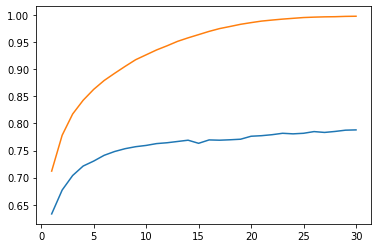

In [43]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val_mod1=[]
accuracies_train_mod1=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy_train = get_accuracy(train_dataloader)
    accuracies_train_mod1.append(accuracy_train)

    accuracy_val = get_accuracy(val_dataloader)
    accuracies_val_mod1.append(accuracy_val)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy_val:.3f}.')
    
plt.plot(range(1, EPOCHS+1), accuracies_val_mod1)

plt.plot(range(1, EPOCHS+1), accuracies_train_mod1)

In [44]:
get_accuracy(test_dataloader)

0.7261548687271518

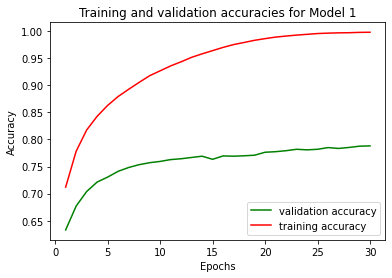

In [46]:
plt.plot(range(1, EPOCHS+1), accuracies_val_mod1, color='g', label='validation accuracy')
plt.plot(range(1, EPOCHS+1), accuracies_train_mod1, color='r', label='training accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracies for Model 1")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

### Model 2- changing hidden dimension

In [47]:
model = NNPOSTagger(window_size = WINDOW_SIZE, 
                    vocab_size = len(vocab_words), 
                     embedding_dim = 300, 
                     hidden_dim = 256, 
                     output_dim = len(vocab_ud),
                     nonlinearity = nn.Tanh(), 
                     use_glove = False,
                     freeze_glove = False).to(device)

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val_mod2=[]
accuracies_train_mod2=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy_train = get_accuracy(train_dataloader)
    accuracies_train_mod2.append(accuracy_train)

    accuracy_val = get_accuracy(val_dataloader)
    accuracies_val_mod2.append(accuracy_val)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy_val:.3f}.')

At iteration 500 the loss is 1.247.
Epoch: 1, time taken: 16.8s, validation accuracy: 0.647.
At iteration 500 the loss is 0.754.
Epoch: 2, time taken: 13.6s, validation accuracy: 0.692.
At iteration 500 the loss is 0.455.
Epoch: 3, time taken: 13.6s, validation accuracy: 0.716.
At iteration 500 the loss is 0.712.
Epoch: 4, time taken: 13.6s, validation accuracy: 0.734.
At iteration 500 the loss is 0.388.
Epoch: 5, time taken: 13.6s, validation accuracy: 0.746.
At iteration 500 the loss is 0.499.
Epoch: 6, time taken: 14.1s, validation accuracy: 0.757.
At iteration 500 the loss is 0.267.
Epoch: 7, time taken: 13.9s, validation accuracy: 0.760.
At iteration 500 the loss is 0.380.
Epoch: 8, time taken: 13.8s, validation accuracy: 0.772.
At iteration 500 the loss is 0.278.
Epoch: 9, time taken: 13.9s, validation accuracy: 0.773.
At iteration 500 the loss is 0.241.
Epoch: 10, time taken: 13.5s, validation accuracy: 0.780.
At iteration 500 the loss is 0.306.
Epoch: 11, time taken: 13.8s, val

In [48]:
get_accuracy(test_dataloader)

0.7274842140245928

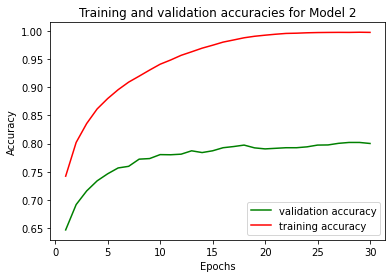

In [50]:
plt.plot(range(1, EPOCHS+1), accuracies_val_mod2, color='g', label='validation accuracy')
plt.plot(range(1, EPOCHS+1), accuracies_train_mod2, color='r', label='training accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracies for Model 2")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

### Model 3- Introducing sparce weights to reduce overfitting

In [56]:
class NNPOSTagger(nn.Module):
    def __init__(self,
                 window_size,
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim,
                 nonlinearity, 
                 # These are used for later tasks
                 use_glove = False, 
                 freeze_glove = False):      
        super(NNPOSTagger, self).__init__()
        self.window_size= window_size
        self.vocab_size= vocab_size
        self.embedding_dim= embedding_dim
        self.hidden_dim= hidden_dim
        self.output_dim= output_dim
        self.nonlinearity= nonlinearity

        self.layer1 = nn.Linear(window_size*embedding_dim, hidden_dim)

        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, sparse= True)
      
        
    def forward(self, word_idxs_batch):
        
        ## WRITE YOUR CODE BELOW.

        embedded = self.embedding(word_idxs_batch)
        embedded_final = embedded.view(len(word_idxs_batch), 600)

        output1 = self.layer1(embedded_final) # will be fed into to get h
        h = self.nonlinearity(output1) # calculating h
        y_tilda = self.layer2(h) #calculating  y-tilde

        y_hat= nn.functional.log_softmax(y_tilda, dim=1)

        return y_hat # this should be of output dimension shape


model = NNPOSTagger(window_size = WINDOW_SIZE, 
                    vocab_size = len(vocab_words), 
                     embedding_dim = 200, 
                     hidden_dim = 64, 
                     output_dim = len(vocab_ud),
                     nonlinearity = nn.Tanh(), 
                     use_glove = False,
                     freeze_glove = False).to(device)

EPOCHS = 100 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

accuracies_val_mod3=[]
accuracies_train_mod3=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy_train = get_accuracy(train_dataloader)
    accuracies_train_mod3.append(accuracy_train)

    accuracy_val = get_accuracy(val_dataloader)
    accuracies_val_mod3.append(accuracy_val)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy_val:.3f}.')

At iteration 500 the loss is 3.334.
Epoch: 1, time taken: 2.1s, validation accuracy: 0.048.
At iteration 500 the loss is 3.272.
Epoch: 2, time taken: 1.7s, validation accuracy: 0.098.
At iteration 500 the loss is 3.206.
Epoch: 3, time taken: 1.7s, validation accuracy: 0.135.
At iteration 500 the loss is 3.071.
Epoch: 4, time taken: 1.6s, validation accuracy: 0.170.
At iteration 500 the loss is 3.068.
Epoch: 5, time taken: 1.6s, validation accuracy: 0.202.
At iteration 500 the loss is 3.089.
Epoch: 6, time taken: 1.6s, validation accuracy: 0.229.
At iteration 500 the loss is 2.996.
Epoch: 7, time taken: 1.7s, validation accuracy: 0.255.
At iteration 500 the loss is 2.843.
Epoch: 8, time taken: 1.6s, validation accuracy: 0.280.
At iteration 500 the loss is 2.878.
Epoch: 9, time taken: 1.7s, validation accuracy: 0.301.
At iteration 500 the loss is 2.778.
Epoch: 10, time taken: 1.7s, validation accuracy: 0.321.
At iteration 500 the loss is 2.803.
Epoch: 11, time taken: 1.7s, validation acc

In [58]:
get_accuracy(test_dataloader)

0.5706214689265536

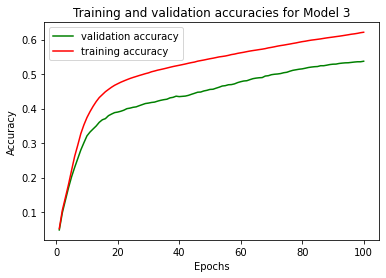

In [57]:
plt.plot(range(1, EPOCHS+1), accuracies_val_mod3, color='g', label='validation accuracy')
plt.plot(range(1, EPOCHS+1), accuracies_train_mod3, color='r', label='training accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracies for Model 3")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

Model 4: Lower dimensions to reduce overfitting


In [59]:
class NNPOSTagger(nn.Module):
    def __init__(self,
                 window_size,
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim,
                 nonlinearity, 
                 # These are used for later tasks
                 use_glove = False, 
                 freeze_glove = False):      
        super(NNPOSTagger, self).__init__()
        self.window_size= window_size
        self.vocab_size= vocab_size
        self.embedding_dim= embedding_dim
        self.hidden_dim= hidden_dim
        self.output_dim= output_dim
        self.nonlinearity= nonlinearity

        self.layer1 = nn.Linear(window_size*embedding_dim, hidden_dim)

        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
      
        
    def forward(self, word_idxs_batch):
        
        ## WRITE YOUR CODE BELOW.

        embedded = self.embedding(word_idxs_batch)
        embedded_final = embedded.view(len(word_idxs_batch), 600)

        output1 = self.layer1(embedded_final) # will be fed into to get h
        h = self.nonlinearity(output1) # calculating h
        y_tilda = self.layer2(h) #calculating  y-tilde

        y_hat= nn.functional.log_softmax(y_tilda, dim=1)

        return y_hat # this should be of output dimension shape


model = NNPOSTagger(window_size = WINDOW_SIZE, 
                    vocab_size = len(vocab_words), 
                     embedding_dim = 200, 
                     hidden_dim = 64, 
                     output_dim = len(vocab_ud),
                     nonlinearity = nn.Tanh(), 
                     use_glove = False,
                     freeze_glove = False).to(device)

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val_mod4=[]
accuracies_train_mod4=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy_train = get_accuracy(train_dataloader)
    accuracies_train_mod4.append(accuracy_train)

    accuracy_val = get_accuracy(val_dataloader)
    accuracies_val_mod4.append(accuracy_val)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy_val:.3f}.')

At iteration 500 the loss is 2.031.
Epoch: 1, time taken: 8.4s, validation accuracy: 0.556.
At iteration 500 the loss is 1.073.
Epoch: 2, time taken: 7.6s, validation accuracy: 0.620.
At iteration 500 the loss is 1.104.
Epoch: 3, time taken: 7.7s, validation accuracy: 0.646.
At iteration 500 the loss is 0.804.
Epoch: 4, time taken: 7.8s, validation accuracy: 0.664.
At iteration 500 the loss is 0.741.
Epoch: 5, time taken: 7.9s, validation accuracy: 0.682.
At iteration 500 the loss is 0.803.
Epoch: 6, time taken: 8.2s, validation accuracy: 0.695.
At iteration 500 the loss is 0.680.
Epoch: 7, time taken: 7.7s, validation accuracy: 0.703.
At iteration 500 the loss is 0.712.
Epoch: 8, time taken: 7.9s, validation accuracy: 0.713.
At iteration 500 the loss is 0.501.
Epoch: 9, time taken: 7.6s, validation accuracy: 0.722.
At iteration 500 the loss is 0.312.
Epoch: 10, time taken: 7.5s, validation accuracy: 0.725.
At iteration 500 the loss is 0.661.
Epoch: 11, time taken: 7.8s, validation acc

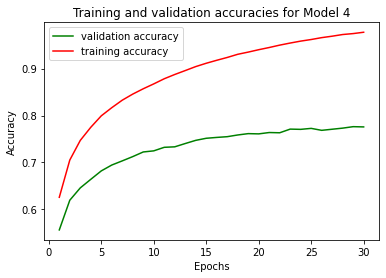

In [61]:
plt.plot(range(1, EPOCHS+1), accuracies_val_mod4, color='g', label='validation accuracy')
plt.plot(range(1, EPOCHS+1), accuracies_train_mod4, color='r', label='training accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracies for Model 4")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()